This code is designed to retrieve surface information from input A-D image files and given instrument response parameters

In [1]:
# Generic imports
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import PIL
import copy
from scipy.interpolate import griddata
from scipy.special import gamma
import scipy.optimize as optimization
import os
import importlib


# Local imports
import sys
sys.path.append('../../../')
import stlstuff as sls
import imagestuff as ims
import facetbrightnessstuff9 as fbs; importlib.reload(fbs)
import f90nml
#import gradstuff as gds

CUDA not available.


In [2]:
%matplotlib notebook

In [7]:
# Specify the file we want to analyze (and output file name)
pwd = os.getcwd()
print(pwd)
startpos = pwd.find('crystals/')
case = pwd[startpos+9:]; print(case)
Segmentnamelistroot = 'Segments1'
imageroot = '2016-06-30_ice1_full2'
Calibrationfile = '../case1 (calibration)/Calibration.nml'

/Users/nesh/Documents/repositories/ice4/crystals/2016-06-30_ice1/case1 (calibration)
2016-06-30_ice1/case1 (calibration)


In [8]:
# Derivative names
Compressedfilename = Segmentnamelistroot+'_retrieved.npz'; print (Compressedfilename)
Roughnessfile = Segmentnamelistroot+'_roughness.jpg'; print(Roughnessfile)
Roughnessdatafile = Segmentnamelistroot+'_roughness.txt'; print(Roughnessdatafile)

Segments1_retrieved.npz
Segments1_roughness.jpg
Segments1_roughness.txt


In [9]:
# These are derivative names
Segmentnamelist = Segmentnamelistroot+'.nml'
Segmentfile = Segmentnamelist
SEMSegmentjpgfile =  Segmentnamelistroot+'.jpg'
Retrievedjpgfile =   Segmentnamelistroot+'retrieved.jpg'
Compressedfilename = Segmentnamelistroot+'retrieved'

In [10]:
# Read the input dataset, including spacing in micrometers
dx,dy,cA,cB,cC,cD,Filename = ims.getc2('', 'SEMimages/', imageroot)
print("Filename, dx and dy", Filename, dx, dy)

Filename, dx and dy SEMimages/2016-06-30_ice1_full2-D.bmp 1.0963399999999999 1.0963399999999999


In [13]:
# This cell loads the image and superimposes the segment boxes

# Load the image
im = PIL.Image.open(Filename)
#im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

# Extract
Segments=f90nml.read(Segmentfile) #reads the file at a given path
nysegments=Segments['Segments']['nysegments']
nxsegments=Segments['Segments']['nxsegments']
nacross=Segments['Segments']['nacross']
ndown=Segments['Segments']['ndown']
nxstart=Segments['Segments']['nxstart']
ny1start=Segments['Segments']['ny1start']
ny2start = ny1start+ndown 
nx1list = []; nx2list = []
ny1list = []; ny2list = []
for ix in range(nxsegments):
    nx1start = nxstart+ix*nacross; nx2start = nxstart+(ix+1)*nacross 
    for i in range(nysegments):
        nx1list.append(nx1start); nx2list.append(nx2start)
        ny1list.append(ny1start+i*ndown); ny2list.append(ny2start+i*ndown)
nsegments = nxsegments*nysegments

# Set up sub-grids in case of multiple segments
nyxgrid = []
for i in range(nsegments):
    nyxgridi = [ (y, x) for y in range(ny1list[i], ny2list[i]+1) for x in range(nx1list[i], nx2list[i]+1) ]
    nyxgrid.append(nyxgridi)

# Add the segments
draw = PIL.ImageDraw.Draw(im)
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)

# Show it
# plt.figure()
# plt.show(im,cmap = 'Greys_r', vmin = 0,vmax = 255)
im.show() # This shouldn't be necessary but there seems to be a bug with plt.show

# Save a copy
im.save(SEMSegmentjpgfile)

# Parameters for selecting out the actual solution
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

# Graphics parameters
surf_ytot = np.linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = np.linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = np.meshgrid(surf_xtot,surf_ytot)

200
150


In [14]:
# Just echo calibration file name
print(Calibrationfile)

# Extract calibration data
Calibration=f90nml.read(Calibrationfile) #reads the file at a given path

../case1 (calibration)/Calibration.nml


In [15]:
# These are parameters important for the retrieval

# Generic retrieval parameters
maxiter = 5
tolerance = 10
rootnoiseamp = 2.5 # This is in SEM image amplitide
rootapriorivar0 = 15 # This is in micrometers

# Size of the kernel (probably don't have to change these)
nptsx = 103
nptsy = 101
nmax = 5

In [16]:
# Retrieve
solution = fbs.retrieveall(\
        nmax,maxiter,tolerance,rootnoiseamp,rootapriorivar0,\
        nsegments,nptsx,nptsy,nx1list,ny1list,nx2list,ny2list,nyxgrid,dx,dy,\
        Calibration,cA,cB,cC,cD)

nxigrid.shape= (101, 103)

for 245 210
Segment: 1 of 12
Observed intensities (detector B):
mean, max, min = 82.4768 100.0 64.0
<diff>, std(diff), di2 = 4.107191503844854 8.64565117519293 114730.11644452339
<diff>, std(diff), di2 = 2.0866165391090346 3.8139688824679885 697.2840846355915
<diff>, std(diff), di2 = 1.932375585718271 3.8303333382138294 3.473610524753616

for 245 260
Segment: 2 of 12
Observed intensities (detector B):
mean, max, min = 82.9676 104.0 66.0
<diff>, std(diff), di2 = 3.772891503844854 8.999174756406742 124372.02986526946
<diff>, std(diff), di2 = 1.637590587665771 3.743576088597931 747.7112740521738
<diff>, std(diff), di2 = 1.472529246518684 3.7420554156575268 2.8861454698650153
Noverlap = 51

for 245 310
Segment: 3 of 12
Observed intensities (detector B):
mean, max, min = 83.714 101.0 66.0
<diff>, std(diff), di2 = 3.420391503844854 9.55850057622652 140768.68671570375
<diff>, std(diff), di2 = 1.115683671578779 3.6501010134386025 894.7677356959006
<diff>, std(diff), 

<IPython.core.display.Javascript object>


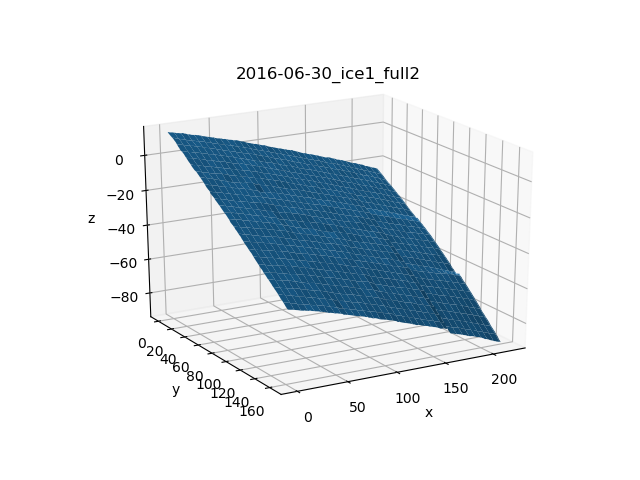

In [17]:
# Show the reconstructed surface
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot, settemp, rstride=6,cstride=6)
ax.invert_yaxis() # invert y axis (this fixes the right-hand-oriented vs left-hand-oriented system)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title(imageroot)
ax.view_init(azim=-120,elev=22)

In [18]:
# Save the image with the retrieved segments
print("saving", Retrievedjpgfile)
fig.savefig(Retrievedjpgfile)

saving Segments1retrieved.jpg


In [19]:
print("saving", Compressedfilename)
np.savez_compressed(Compressedfilename, \
                    surfaceroot=imageroot, \
                    imageroot=imageroot, \
                    nx1list=nx1list, \
                    nx2list=nx2list, \
                    ny1list=ny1list, \
                    ny2list=ny2list, \
                    solution=solution)

saving Segments1retrieved
